$$
\renewcommand{\erf}{\operatorname{erf}}
$$

# Integração Numérica

Imagine que estamos interessado em calcular a integral de uma função $f$ em um intervalo $[a, b]$.
$$
I \equiv \int_a^b f(x) dx.
$$
Em cálculo vimos que isso pode ser feito usando o teorema fundametal do cálculo sempre que conhecemos uma primitiva de $f$. Infelizmente em alguns casos não conhecemos uma primitiva. Um exemplo interessante é a integral
$$
\erf(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt
$$
para qual não se conhece primitiva usando função usuais.

Há ainda outras situações em que o processo de calcular a intergral a partir de uma primitiva pode ser indesejável ou impossível. Por exemplo, a expressão da primitiva pode ser muito complexa ou não conhecemos a expressão explícita de $f$ mas apenas temos $f$ tabelada em alguns pontos.

Nesses casos uma possibilidade interessante é tentar realizar uma integração numérica de $f$, ou seja, tentar encontrar aproximações da integral desejada usando fórmulas que envolvam apenas o cômputo da função que se deseja integrar em alguns pontos pré-escolhidos ou mesmo nos pontos que temos à disposição. Vamos ver algumas alternativas para isso.

## Regra do trapézio

Imagine que queremos integrar uma função $f$ no intervalo $[a, b]$. Uma das possibilidades mais simples é aproximar a integral pela área do trapézio definido por $(a, f(a))$ e $(b, f(b))$.


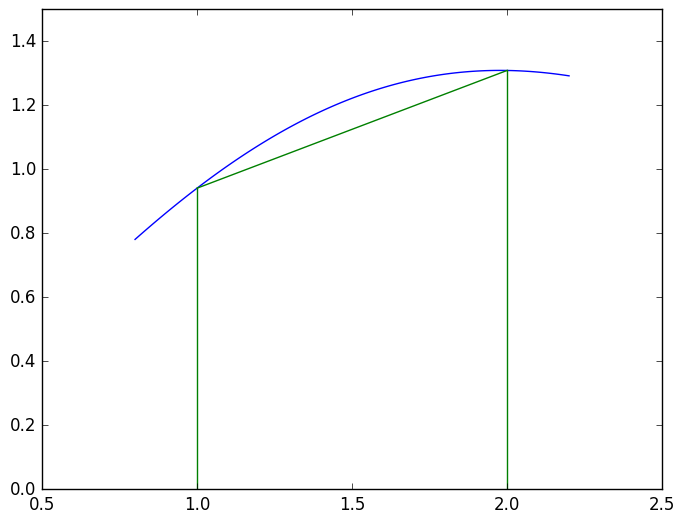

In [1]:
using PyPlot
axis([0.5, 2.5, 0.0, 1.5])
f(x) = sin(x) + 0.1*x.^2
a, b = 1, 2.0
x = linspace(a - 0.2, b + 0.2, 100)

# Desenha f
plot(x, f(x))

#Desenha o polinomio interpolador de f
plot([a, b], [f(a), f(b)], color="g")

# Desenha duas linhas verticais para facilitar a visualizacao
plot([a, a], [0.0, f(a)], color="g")
plot([b, b], [0.0, f(b)], color="g");

Se chamarmos a distância entre $a$ e $b$ de $h$, temos imediatamente a aproximação
$$
\int_a^b f(x) dx \approx \frac{f(a) + f(b)}{2}h \equiv Q_T[f].
$$
Que no caso acima resulta em.

In [2]:
# Valor aproximado.
println("Valor aproximado: ", (f(1.0) + f(2.0))/2.0)

# Podemos comparar com o valor exato já que é fácil calcular a primitiva de f.
F(x) = -cos(x) + 0.1/3.0*x.^3
println("valor exato: ", F(2.0) - F(1.0))

Valor aproximado: 1.125384205816789
valor exato: 1.1897824757486155


Como podemos ver a fórmula simples de aproximação acima já acerta a primeira casa do resultado e erro por pouco a segunda. 

Agora como podemos melhorar isso? Basta seguir a ideia da definição de integral e subdividir o intervalo $[a, b]$ em $n$ intervalos menores, isto é definir pontos $a = x_0 < x_1 < x_2 < \ldots < x_n = b$. Para simplificar vamos sempre considerar que os intervalos tem todos os mesmos tamanhos que chamaremos mais uma vez de $h$. Podemos então usar a fórmula do trapézio em cada subintervalo e por fim somar todas as áreas obtidas para a aproximar a área total. Ou seja fazemos
\begin{align*}
\int_a^b f(x) dx &\approx h \left( \frac{f(x_0) + f(x_1)}{2} + \frac{f(x_1) + f(x_2)}{2} + \dots + \frac{f(x_{n - 1}) + f(x_n)}{2} \right) \\
&= h \left( \frac{f(x_0)}{2} + f(x_1) + f(x_2) + \ldots + f(x_{n - 1}) + \frac{f(x_n)}{2} \right) \equiv Q_{TC}[f].
\end{align*}
Essa fórmula é conhecida com regra do trapézio composta. Vamos vê-la em ação.

In [3]:
# Integracao numérica usando a regra dos trapezios composta com n + 1 pontos.
function TC(f, a, b, n=10)
    h = (b - a) / n
    integral = 0.5*(f(a) + f(b))
    x = a + h
    for i = 1:n-1
        integral += f(x)
        x += h
    end
    return h*integral
end

n = 10
I= F(b) - F(a)
println("Intergral exata: ", I)
aprox = TC(f, a, b, n)
println("Integral aproximada: ", aprox)
@printf "Erro relativo: %e\n" abs(I - aprox)/abs(I);

Intergral exata: 1.1897824757486155
Integral aproximada: 1.1891519685914744
Erro relativo: 5.299348e-04


Também devemos destacar que a hipótese de que todos os subintervalos são do mesmo comprimento apenas ajuda a simplificar a expressão, já que podemos usar a notação unificadora $h$ para esse comprimento. Caso os subintervalos tenham tamanhos distintos podemos ainda escrever
$$
\int_a^b f(x) dx \approx \frac{(x_1 - x_0)(f(x_0) + f(x_1))}{2} + \frac{(x_2 - x_1)(f(x_1) + f(x_2))}{2} + \dots + \frac{(x_n - x_{n -1})(f(x_{n - 1}) + f(x_n))}{2}, 
$$
em que cada comprimento de subintervalo é aparece explicitamente.

Outra observação interessante é que a regra do trapézio composta é equivalente a primeiro aproximarmos a função $f$ por uma spline linear para em seguida usarmos a integral da spline, que é exatamente $Q_{TC}[f]$, como aproximação da integral de $f$. Nesse contexto é interessante vermos se somos capazes de estimar o erro ao aproximar a integral, assim como conseguimos aproximar o erro em uma interpolação polinomial ou por splines. 

Para isso, vamos iniciar pensando na regra do trapézio simples. Nesse caso a fórmula do erro de interpolação por um polinômio de grau 1 garante que
$$
\forall x \in [a, b],\ \exists \xi_x \in (a, b),\quad f(x) - p_1(x) = \frac{f''(\xi_x)}{2!}(x - a)(x - b).
$$
Segue imediatamente que
\begin{align}
I - Q_T[f] = \int_a^b f(x) dx - \int_a^b p_1(x) dx &= \int_a^b \frac{f''(\xi_x)}{2}(x - a)(x - b) dx \\
&= \frac{f''(\eta)}{2} \int_a^b (x - a)(x - b) dx \\
&= -\frac{(b - a)^3}{12} f''(\eta)
\end{align}
para algum $\eta \in (a, b)$. A segunda igualdade é consequência do teorema do valor médio para integrais que pode ser usado porque $(x - a)(x - b)$ não troca de sinal no intervalo $[a, b]$.

Note que em particular se a segunda derivada de $f$ em $(a, b)$ for identicamente nula, ou seja se $f$ for afim em $[a, b]$ então a integral aproximada é exatamente igual a integral de $f$ como podíamos esperar.

O que essa fórmula nos ensina é que ela somente é interessante quando o tamanho do intervalo é pequeno. Se o intervalo de integração for grande teremos que subdividí-lo, usando a regra composta. No caso podemos aplicar a fórmula de erro da integração em cada subintervalo o obteremos algo como:
\begin{align}
I - Q_{TC}[f] &= \text{Soma dos erros em cada subintervalo} \\
&= -\frac{n h^3}{12} \sum_{i = 1}^n \frac{f''(\eta_i)}{n} \\
&= -\frac{n h^3}{12} f''(\eta),\quad \eta \in (a, b).
\end{align}
Lebrando que $nh = b - a$, temos
$$
I - Q_{TC}[f] = -\frac{(b - a) h^2}{12} f''(\eta),\quad \eta \in (a, b).
$$

Um dos usos importantes desse tipo de resultado é estimar quantos pontos são necessários para atingir uma precisão desejada.

#### Exemplo

Quantos pontos no intervalo $[0, 1]$ são necessários para estimar a integral
$$
I = \int_0^1 e^{-x^2} dx
$$ 
com erro menor ou igual a $10^{-4}$?

Sabemos que 
$$
| I - Q_{TC} | \leq \frac{(b - a)h^2}{12} M_2,
$$
em que $M_2$ é um limitante superior para o módulo da derivada segunda de $f$ que é $f''(x) = (4x^2 - 2)e^{-x^2}$. Vamos estimar $M_2$. Para $x \in [0, 1]$,
$$
|(4x^2 - 2)e^{-x^2}| \leq (4\cdot1^2 - 2)e^0 = 2.
$$
A desigualdade se justifica porque a primeira função do produto varia de -2 a 2 quando $x$ varia de 0 a 1. Já a segunda função tem o módulo decrescente com $x$. Podemos então tomar $M_2 = 2$ acima e concluir que
$$
| I - Q_{TC} | \leq \frac{h^2}{12} 2 \leq 10^{-4}.
$$
De onde vemos que precisamos escolher $h$ tal que
$$
h \leq \sqrt{6} \cdot 10^{-2} \implies n \geq 41.
$$
Note que na estimativa acima estamos considerando um limitante superior para para o módulo da segunda derivada. De fato é possível atingir a precisão desejada com $n$ menor, como vemos no código abaixo.

In [4]:
# Dados da funcao, primitiva e extremos de integracao.
f(x) = exp(-x.^2)
F(x) = sqrt(pi)/2.0*erf(x)
a = 0.0
b = 1.0

# Aproxima e calcula o erro
n = 25
I = F(b) - F(a)
println("Integral exata: ", I)
aprox = TC(f, a, b, n)
println("Integral aproximada: ", aprox)
@printf "Erro absoluto: %e\n" abs(I - aprox);

Integral exata: 0.746824132812427
Integral aproximada: 0.746726026396451
Erro absoluto: 9.810642e-05


Vemos que com 26 pontos já conseguimos o erro menor que $10^{-4}$, bem menos que os $41$ estimados.

Em resumo temos uma regra bastante simples, que pode ser usada inclusive com intervalos irregulares se as alterações óbvias forem feitas. O erro de integração com múltiplos intervalos cai com $h^2$. 

Mas será que podemos fazer melhor do que isso?

## Regra de Simpson

Podemos obter outras regras de aproximação de integrais simplesmente usando splines de ordem mais alta. Por exemplo, podemos usar uma spline quadrática que interpole $f$ em três pontos consecutivos. Nesse caso, precisamos avaliar $f$ em pelo menos três pontos. Se considerarmos um intervalo $[a, b]$ e $m$ seu ponto médio o polinômio interpolador fica:
$$
p_2(x) = f_a + \frac{x - a}{h} \left( (f_m - f_a) + \frac{f_b - 2f_m + f_a}{2h} (x - m) \right),
$$
em que $h = (b - a)/2$, ou seja a distância entre dois pontos de interpolação. Para ver que o polinômio acima interpola $f$ em $a$, $m$ e $b$ basta calcular o seu valor nesses pontos e ver que ele recupera os valores originais $f_a = f(a)$, $f_m = f(m)$ e $f_b = f(b)$.

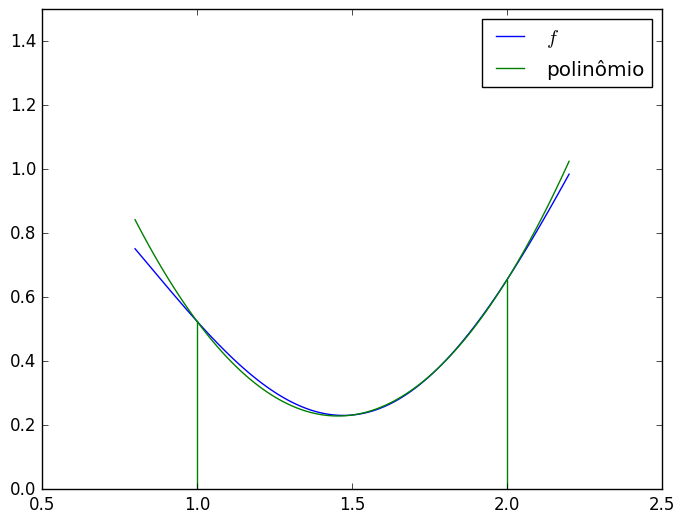

In [5]:
using PyPlot
axis([0.5, 2.5, 0.0, 1.5])
f(x) = sin(x) + cos(2*x)+ 0.1*x.^2
a, b = 1.0, 2.0
m = (b + a) / 2
x = linspace(a - 0.2, b + 0.2, 100)

# Desenha f
plot(x, f(x), label=L"$f$")

#Desenha o polinomio interpolador de grau 2 de f
h = (b - a) / 2
fa = f(a)
fb = f(b)
fm = f(m)
p2(x) = fa + (x - a)/h .* ((fm - fa) + (fb - 2*fm + fa)/(2*h) .* (x - m) )
plot(x, p2(x), color = "g", label="polinômio")
legend()

# Desenha duas linhas verticais para facilitar a visualizacao
plot([a, a], [0.0, f(a)], color="g")
plot([b, b], [0.0, f(b)], color="g");

Apesar da fórmula de $p_2(x)$ ser um pouco assustadora, a fórmula de sua integral é simples:
$$
I = \int_a^b f(x) dx \approx \int_a^b p_2(x) dx = \frac{h}{3}(f_a + 4f_m + f_b) \equiv Q_S[f].
$$

Aplicando essa fórmula no exemplo acima temos.

In [6]:
# Primitiva
F(x) = -cos(x) + sin(2*x)/2 + 0.1/3*x.^3

println("Integral exata: ", F(2.0) - F(1.0))
println("Integral aproximada por Simpson: ", 0.5/3.0*(f(1.0) + 4*f(1.5) + f(2.0)))

Integral exata: 0.35673251468181055
Integral aproximada por Simpson: 0.3518313190395433


Agora como estender essa fórmula subdividindo o intervalo? Nesse caso precisamos de um número par de pontos para poder separar os grupos em 3 em 3 com extremos comuns em um esquema semelhante ao sugerido abaixo.

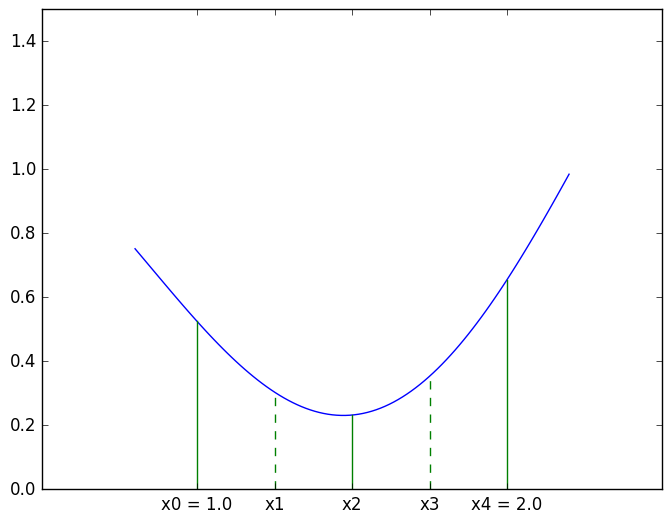

In [7]:
axis([0.5, 2.5, 0.0, 1.5])

# Desenha f
a, b = 1.0, 2.0
z = linspace(a - 0.2, b + 0.2, 100)
plot(z, f(z))

# Desenha duas linhas verticais para facilitar a visualizacao
n = 4
h = (b - a)/n
x = linspace(a, b, n + 1)

plot([x[1], x[1]], [0.0, f(x[1])], color="g")
plot([x[2], x[2]], [0.0, f(x[2])], color="g", linestyle="--")
plot([x[3], x[3]], [0.0, f(x[3])], color="g")
plot([x[4], x[4]], [0.0, f(x[4])], color="g", linestyle="--")
plot([x[5], x[5]], [0.0, f(x[5])], color="g")
xticks(x, ["x0 = 1.0", "x1", "x2", "x3", "x4 = 2.0"]);

Ou seja, quebramos o intervalo de integração em grupos de dois em dois subintervalos a aplicamos a regra de Simpson em cada um deles.

Isso, é claro pode ser generalizado para mais intervalos. Se temos $n + 1 $ pontos, com $n$ par, podemos construir $n / 2$ intervalos e obtemos a fórmula
$$
I = \int_a^b f(x) dx = \sum_{k = 1}^{n/2} \int_{x_{2k - 2}}^{x_{2k}} f(x) dx \approx \sum_{k = 1}^{n /2} \frac{h}{3} [f(x_{2k-2}) + 4 f(x_{2k - 1}) + f(x_{2k}) ] \equiv Q_{SC}[f].
$$
conhecida como regra de Simpson composta.

Mais uma vez podemos implementá-la.

In [8]:
# Dados
f(x) = sin(x) + 0.1*x.^2
F(x) = -cos(x) + 0.1/3.0*x.^3
# Integracao numérica usando a regra de Simpson composta com n + 1 pontos.
# n deve ser par
function SC(f, a, b, n=10)
    h = (b - a) / n
    integral = f(a) + f(b)
    x = a + h
    for i = 1:n-1
        if i % 2 == 0
            integral += 2*f(x)
        else
            integral += 4*f(x)
        end
        x += h
    end
    return (h/3)*integral
end

n = 10
I = F(b) - F(a)
aproxTC = TC(f, a, b, n)
aproxSC = SC(f, a, b, n)
println("Integral exata: ", I)
println("Aproximaçãopor trapézios compostos: ", aproxTC)
println("Aproximaçãopor Simposon composta: ", aproxSC)
@printf "Erro relativo ao usar trapézios compostos: %e\n" abs(I - aproxTC)/abs(I)
@printf "Erro relativo ao usar Simpson composta: %e\n" abs(I - aproxSC)/abs(I)

Integral exata: 1.1897824757486155
Aproximaçãopor trapézios compostos: 1.1891519685914744
Aproximaçãopor Simposon composta: 1.1897830077424874
Erro relativo ao usar trapézios compostos: 5.299348e-04
Erro relativo ao usar Simpson composta: 4.471354e-07


Veja que o resultado obtido pelo emprego da regra de Simpson composta é bem melhor do que o resultado obtido pela regra dos trapézios composta. Uma limitação da regra Simpson é que ela assume que os intervalos entre os pontos são sempre de mesmo comprimento, isso foi usando quando apresentamos a fórmula do polinômio interpolador de segundo grau.

No caso da regra de Simpson é também possível estimar o erro esperado e observar que, qualitativamente, ele deve ser menor do que o erro da regra dos trapézios. De fato, usando uma análise semelhante a feita no caso dos trapézios podemos obter a seguinte expressão para o erro na regra de Simpson em um intervalo.
\begin{align}
|I - Q_S[f]| = \int_a^b f(x) dx - \int_a^b p_2(x) dx &= \left| \int_a^b \frac{f'''(\xi_x)}{3!}(x - a)(x - m)(x - b) dx \right| \\
&\leq \int_a^b \frac{| f'''(\xi_x)|}{3!} \left| (x - a)(x - m)(x - b) dx \right| \\
&= \frac{| f'''(\eta) |}{6} \int_a^b | (x - a)(x - m)(x - b) | dx, \quad \eta \in (a, b) \\
&= \frac{| f'''(\eta) |}{6} \frac{1}{2} \left( \frac{b - a}{2} \right)^4, \quad \eta \in (a, b) \\
&= \frac{| f'''(\eta) | h^4}{12}, \quad \eta \in (a, b).
\end{align}
De novo usamos o teorema do valor intermediário para integrais na passagem mais complicada e o fato que $h = (b - a)/2$. Compare com o resultado obtido para o caso do método dos trapézios em particular observe que há uma tendência do erro ser menor já que a potência do $h$ é maior.

Agora, uma análise um pouco mais sofisticada da expressão original permite provar que:
$$
I - Q_S[f] = -\frac{f^{(4)}(\eta)h^5}{90}, \quad \eta \in (a, b).
$$
Note que, como o erro depende da derivada quarta de $f$, se a função original for um polinômio de grau até 3 o erro será zero. Isso é mais do que era esperado pela estratégia de construção da regra já que polinômio interpolador usado foi de grau 2. A potência real de $h$ também é maior, aumentando para 5. Esse fenômeno poderá ser melhor entendio abaixo quando falarmos de quadratura gaussiana. Mas de qualquer forma podemos verificar isso empirifamente com o programa:

In [18]:
# Um polinômio bem complicado de grau 3.
p(x) = π*x.^3 + e*x.^2 + 2*x + 13
# Sua primitiva, como é polinômio é fácil calcular.
prim_p(x) = π*(x.^4/4) + e*(x.^3/3) + 2*(x.^2/2) + 13*x
valor_simpson = SC(p, a, b, 2)
valor_exato = prim_p(b) - prim_p(a)
println("Valor calculado por Simpson simples: ", valor_simpson)
println("Valor exato, baseado na primitiva: ", valor_exato)
println("Erro relativo: ", abs(valor_simpson - valor_exato)/abs(valor_exato))

Valor calculado por Simpson simples: 34.1236300506995
Valor exato, baseado na primitiva: 34.123630050699504
Erro relativo: 2.0822601074516534e-16


Como você pode ver os dois valores diferem apenas dentro do epsilon da máquina, como a fórmula acima previa!

Agora que sabemos o que ocorre com a regra simples, podemos estimar o que ocorre na regra de Simpson composta. Mais uma vez fazendo uma somatória obtemos.
$$
I - Q_{SC}[f] = -\frac{n}{2}\frac{h^5}{90}f^{(4)}(\eta) = -\frac{(b - a)h^4}{180} f^{(4)}(\eta),\quad \eta \in (a, b).
$$
Veja que o erro cai com $h^4$ que é potencialmente bem menor do que $h^2$ para $h$ pequeno. Isso confirma o resultado numérico obtido quando comparamos as duas regras.

Podemos usar esses limitantes para obter estimativas do número necessários de pontos para conseguir uma precisão desejada, ou qual a precisão mínima esperada se usarmos uma quantidade de pontos dada. 

#### Exemplo

Em quantos pontos são necessários para particionar o intervalo $[0, 1]$ para estimar a integral
$$
\int_0^1 e^{-x^2} dx
$$
com erro menor ou igual a $10^{-4}$?

Lembrando que já tínhamos calculado a derivada segunda da função que estamos integrando podemos partir de $f''(x) = (4x^2 - 2)e^{-x^2}$ e calcular as próximas derivadas chegando a $f^{(4)}(x) = 4(4x^4 - 12x^2 + 3)e^{-x^2}$. Obtemos então $12$ como limitante de $M_4$, já que o polinômio e a exponencial atingem máximo em $x = 0$. Teremos
\begin{gather}
| I - Q_{SC}| \leq \frac{(b - a)h^4}{180}M_4 \leq \frac{h^4}{180} 12 \leq 10^{-4} \implies \\
h^4 \leq 15\cdot10^{-4}.
\end{gather}
Como $h = (b - a)/n$, obtemos $n \geq 5,09$, basta tomar $n \geq 6$ (lembre que temos que tomar $n$ par também, nesse caso isso veio naturalmente). Vamos verificar com o programa.

In [33]:
@show aproxSC = SC(f, a, b, 6)
@show abs(I - aproxSC);

aproxSC = SC(f,a,b,6) = 1.1897865893513873
abs(I - aproxSC) = 4.113602771749214e-6


E de fato vemos que a precisão obtida foi menor do que $10^{-4}$.

## Newton-Cotes

Como já vimos, uma forma simples de gerar novas regras de aproximação de integrais é escolher pontos dentro do intervalo integração na forma $a = x_0 < x_1 < \ldots < x_n = b$ e passar por esses pontos um polinômio interpolador. Tipicamente esses pontos intermediários são igualmente espaçados. Essa foi a forma que usamos para obter as regras do trapézio e de Simpson.

Por outro lado, lembrando da expressão geral do polinômio interpolador, dada por Legendre, temos para um polinômio de grau arbitrário:
\begin{align}
I = \int_a^b f(x) dx &\approx \int_a^b p_n(x) dx \\
&=\int_a^b \sum_{k = 0}^n f(x_k)l^n_k(x) dx \\
&=\sum_{k = 0}^n f(x_k) \int_a^b l^n_k(x) dx.
\end{align}
Se chamarmos de $A_k$ os valores $\int_{a}^{b} l^{n}_{k}(x) dx$, $k = 0, \ldots, n$, temos a fórmula
$$
I = \int_a^b f(x) dx \approx \sum_{k = 0}^n A_k f(x_k) \equiv Q_n[f].
$$
Ou seja, as integrais são aproximadas por somatórias de pesos $A_k$ vezes os valores de $f$ nos pontos $x_k$. Além disso essa fórmula nos mostra que para definir uma dessas regras basta encontrar os pesos $A_k$. Esses podem ser obtidos integrando os polinômios de Legendre o que precisa ser feito uma única vez. 

Outra possibilidade é lembrar que os pesos $A_k$ devem ser escolhidos para garantir que a integral de polinômios de ordem até $n$ sejam exatas. Como a integral da soma é a soma das integrais isso pode ser garantido simplesmente pedindo que as equações
$$
Q_n[x^k] = \int_{a}^b x^k dx, k = 0, \ldots, n
$$
Sejam válidas exatamente.

Resolver essas equações é muitas vezes mais simples do que calcular as integrais dos polinômios de Legendre. Vamos ver o exemplo de Simpson. Nesse caso temos $x_0 = a,\ x_1 = (a+b) /2,\ x_2 = b$. As equaçoes acima ficam:
\begin{align}
\int_a^b 1 dx = (b - a) &= A_0 + A_1 + A_2 && [\text{Aqui } f(x) = x^0 = 1] \\
\int_a^b x dx = \frac{b^2 - a^2}{2} &= A_0a + A_1\frac{a + b}{2} + A_2b && [\text{Aqui } f(x) = x] \\
\int_a^b x^2 dx = \frac{b^3 - a^3}{3} &= A_0a^2 + A_1\frac{(a + b)^2}{4} + A_2b^2 && [\text{Aqui } f(x) = x^2].
\end{align}
O que fornece um sistema de três equações com três icógnitas. Esse sistema pode fer facilmente resolvido no computador para um caso específico em que $a$ e $b$ são conhecidos, obtendo assim os respectivos $A_0,\ A_1,\ A_3$. De fato, esse sistema pode ser resolvido de forma genérica dando
$$
A_0 = A_2 = \frac{b - a}{6},\quad A_1 = \frac{4(b-a)}{6}.
$$
Substituindo na fórmula geral da integral obtemos exatamente a fórmula de Simpson
$$
I = \int_a^b f(x) dx \approx \sum_{k = 0}^n A_k f(x_k) = \frac{b-a}{6}\left[f(a) + 4 f\left(\frac{a + b}{2}\right) + f(b) \right],
$$
lembre que o $h$ que aparece na fórmula original é metade do comprimento do intervalo e assim as duas fórmulas são iguais.

Essa mesma estratégia pode ser usada para obter fórmulas para polinômios de qualquer grau, seguindo o seguinte roteiro, conhecido como abordagem de Newton-Cotes.

1. Divide-se o intervalo $[a, b]$ usando $n$ pontos, tipicamente igualmente espaçados.

1. Resolve-se o sistema de equações em $A_k,\ k = 0, \ldots, n$
$$
A_0 x_0^k + A_1 x_1^k + \ldots A_n x_n^k = \int_{a}^b x^k dx,\quad k = 0, \ldots n.
$$

1. A integral de uma função geral é então aproximada por 
$$
I = \int_a^b f(x) dx \approx \sum_{k = 0}^n A_k f(x_k).
$$

Em geral não é bom usar polinômios de grau muito alto, pelos menos problemas já citados quando vimos interpolação polinomial. Nesse caso a solução natural para usar mais pontos é fazer uma variante de fórmula compondo intervalos consecutivos.

## Quadratura Gaussiana

Vimos nas fórmulas de Newton-Cottes que podemos aproximar
$$
I = \int_a^b f(x) dx \approx \sum_{k = 0}^n A_k f(x_k),
$$
escolhendo os coeficientes $A_k,\ k = 0, \ldots, n$ de forma adequada.

Uma opção interessante, quando podemos calcular $f$ em qualquer lugar e não apenas em pontos pré-fixados, é ver se podemos ganhar algo considerando que podemos escolher também a posição dos pontos $x_0, x_1, \ldots, x_n$ dentro do intervalod $[a, b]$. Nesse caso teríamos ao todo $2n$ icógnitas e obteríamos a abordagem da _Quadratura Gausssiana_. 

Para ver como isso funciona vamos ver o caso simples de $x = 1$ com $[a, b] = [-1, 1]$. Nesse caso queremos aproximar 
$$
I = \int_{-1}^1 f(x) dx \approx A_0 f(x_0) + A_1 f(x_1),
$$
e podemos escolher tanto os coeficientes $A_0, A_1$ e os pontos $x_0, x_1$ (no intervalo). Como são quatro icógnitas podemos tentar forçar quatro equações para polinômios de grau até 3. Resultado no sistema
\begin{align*}
Q[1] = \int_{-1}^1 1 dx = 2 &= A_0 + A_1 \\
Q[x] = \int_{-1}^1 x dx = 0 &= A_0x_0 + A_1x_1 \\
Q[x^2] = \int_{-1}^1 x^2 dx = \frac{2}{3} &= A_0x_0^2 + A_1x_1^2 \\
Q[x^3] = \int_{-1}^1 x^3 dx = 0 &= A_0x_0^3 + A_1x_1^3 \\
\end{align*}
Note que o sistema obtido é não linear, sendo então muito mais complexo para resolver que o sistema linear de uma fórmula de Newton-Cottes. Com algum esforço podemos resolver o sistema acima obtendo
$$
A_0 = A_1 = 1,\quad x_0=-\frac{\sqrt{3}}{3} = -x_1.
$$
O que nos dá a fórmula de Gauss-Legendre de integração:
$$
I = \int_{-1}^1 f(x) dx \approx f\left( -\frac{\sqrt{3}}{3} \right) + f\left( -\frac{\sqrt{3}}{3} \right).
$$
Que usando apenas dois pontos consegue ser exata para polinômios de grau até 3. 

Observe que o o fato do intervalo de integração ser fixo $[-1, 1]$ não é de grande importância. A integral de uma função em um intervalo qualquer $[a, b]$ pode ser transformada na integral de uma outra semelhante em $[-1, 1]$ que é obtida da função original através de translação e mudança de escala dos argumentos. Pense em como fazer isso.


Vamos implementar a regra de Gauss-Legendre e comparar com o método do Trapézio.

In [34]:
# Dados
f(x) = exp(-x.^2)
F(x) = sqrt(pi)/2.0*erf(x)
a = -1.0
b = 1.0

# Integracao numérica usando a regra de Gauss Legenre para [-1, 1].
function GL(f)
    arg = sqrt(3)/3
    return f(-arg) + f(arg)
end

I = F(1) - F(-1)
aproxT = TC(f, -1, 1, 1)
aproxGL = GL(f)
@printf "Erro relativo com a regra do trapézio: %e\n" abs(I - aproxT)/abs(I)
@printf "Erro relativo com a regra de Gauss-Legendre: %e\n" abs(I - aproxGL)/abs(I)

Erro relativo com a regra do trapézio: 5.074082e-01
Erro relativo com a regra de Gauss-Legendre: 4.056219e-02


É claro que também é possível fazer uma versão composta da regra de Gauss-Legendre, que resulta em bons resultados com poucas avaliações das funções.

Isso pode ser generalizado para polinômios de grau mais alto usando-se a ideia de polinômios ortogonais. Porém isso foge ao escopo do curso.